In [17]:
import flappy_bird_env
import gymnasium
import torch
from gymnasium.utils.play import play
import numpy as np
import pygame
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy import stats
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

Характеристики среды:
    Имеется 2 действия. 1: сделать рывок вверх. 0: ничего не делать.
    Состояния: Изначально среда передавала изображение размерностью 800 * 576 * 3, но мы решили работать с 6 числами. Координаты и размеры трубы, и координаты птички.
    Ревард: +1 за каждую пройденную трубу и + 0.001 за каждый пройденный кадр без коллизии

In [2]:
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array")

В этой ячейке можно запустить игру и поиграть в неё. 

In [284]:
# play(env, keys_to_action={(pygame.K_SPACE,): np.array([1])}, noop=np.array([0]),
#      fps=24)

In [285]:
env.action_space

Discrete(2)

# Задание 1. $\varepsilon$-жадная стратегия с эстиматором. 

In [5]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
            probs = torch.ones(n_action) * epsilon / n_action
            q_values = estimator.predict(state)
            best_action = torch.argmax(q_values).item()
            probs[best_action] += 1.0 - epsilon
            action = torch.multinomial(probs, 1).item()
            return action 
    return policy_function

In [6]:
class LR_Estimate():
    def __init__(self, n_feat, n_state, n_action, lr=0.05):#n_state - размерность состояний теперь
        self.w, self.b = self.get_gaussian_wb(n_feat,n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()
        for _ in range(n_action):
            model = torch.nn.Linear(n_feat,1)
            self.models.append(model)
            optimizer = torch.optim.SGD(model.parameters(), lr)
            self.optimizers.append(optimizer)

    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        torch.manual_seed(0)
        w = torch.randn((n_state,n_feat))/sigma
        b = torch.rand((n_feat))* 2.0 * math.pi
        return w, b

    def get_feature(self, s):
        features = (2.0 / self.n_feat) ** 0.5 * torch.cos(torch.matmul(torch.tensor(s).float().T, self.w) + self.b)
        
        return features

    def update(self, s, a, y):
        features = Variable(self.get_feature(s))
        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()

    def predict(self,s):
        features = self.get_feature(s)
        # print(features)
        with torch.no_grad():
            m = [model(features) for model in self.models]
            b = torch.Tensor(len(m), len(m[0]))
            
            torch.cat(m, out=b)
            return b

In [288]:
estimator = LR_Estimate(10, 6, env.action_space.n)
policy = gen_epsilon_greedy_policy(estimator, 0.1, env.action_space.n)

In [296]:
rewards = np.zeros(30)
for traj_num in range(30):
    info = env.reset()
    state = np.array(list(info[1]['pipes'][-1].values()) + list(info[1]['bird'].values()))
    is_done = False
    for ___ in range(100):
        if is_done:
            break
        action = policy(state)
        new_state, reward, is_done, __,  info = env.step(action)
        state = np.array(list(info['pipes'][-1].values()) + list(info['bird'].values()))
        rewards[traj_num] += reward 

/tmp/ipykernel_19126/3857906204.py:42: UserWarning: An output with one or more elements was resized since it had shape [2, 1], which does not match the required output shape [2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:26.)
  torch.cat(m, out=b)


Точечная оценка наших ревардов.

In [297]:
mean_rew = sum(rewards) / len(rewards)
print(mean_rew)

0.060733333333333354


Интервальная оценка

In [298]:
interval = stats.norm.interval(0.95, loc=mean_rew, scale=stats.tstd(rewards, axis=0))
print(interval)

(0.019335231582902714, 0.10213143508376399)


# Задание 2. Алгоритм Q-learning

Мы взяли именно Q-learning с эстиматором для того, чтобы заменить ценности состояний более компактной моделью, чем таблица точных значений. Также Q-learning будет работать чуть быстрее, чем SARSA, т.к. здесь у нас нет «исследовательского шага», но вообще для каждой среды это индивидуально.

Источник: https://medium.rip/codex/temporal-difference-learning-sarsa-vs-q-learning-c367934b8bcc

P.S. Чтобы открывать статьи медиума без vpn, можно заменить .com на .rip, это доступное нам зеркало. Правда, там не будет картинок

In [16]:
def q_learning(env, estimator, n_episode, epsilon, n_action, gamma=1.0, epsilon_decay=0.99):
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        
        info = env.reset()
        state = np.array(list(info[1]['pipes'][-1].values()) + list(info[1]['bird'].values()))
        is_done = False
        
        while not is_done:
            action = policy(state)
            
            new_state, reward, is_done, __,  info = env.step(action)
            near_pipe = min(info['pipes'], key= lambda x: abs(x['x'] - info['bird']['x']))
            new_state = np.array(list(near_pipe.values()) + list(info['bird'].values()))
            
            q_values_next = estimator.predict(new_state)
            td_target = reward + gamma * torch.max(q_values_next)
            
            estimator.update(state, action, td_target)
            
            total_reward_episode[episode] += reward
        state = new_state

In [7]:
n_state = 6
n_action = env.action_space.n
n_feature = 5
lr = 0.03
estimator = LR_Estimate(n_feature, n_state, n_action, lr)

n_episode = 300
total_reward_episode = [0] * n_episode
q_learning(env, estimator, n_episode, 0.1, n_action)

C:\Users\Людмила\AppData\Local\Temp\ipykernel_14124\3857906204.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  features = (2.0 / self.n_feat) ** 0.5 * torch.cos(torch.matmul(torch.tensor(s).float().T, self.w) + self.b)
C:\Users\Людмила\AppData\Local\Temp\ipykernel_14124\3857906204.py:42: UserWarning: An output with one or more elements was resized since it had shape [2, 1], which does not match the required output shape [2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at 

Точечная оценка наших ревардов.

In [12]:
mean_rew = sum(total_reward_episode) / len(total_reward_episode)
print(mean_rew)

0.033016666666666715


Интервальная оценка

In [15]:
interval = stats.norm.interval(0.95, loc=mean_rew, scale=stats.tstd(total_reward_episode, axis=0))
print(interval)

(0.025531501450545037, 0.04050183188278839)


Видно, что хоть и среднее значение уменьшилось, уменьшился также и разброс значений.

In [10]:
plt.plot(total_reward_episode, 'b.')
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

На графике видно, что птичка не может перелететь даже через первую трубу. Вообще, это даже вручную сделать тяжело, т.к. среда немного кривенькая, и игра здесь намного сложнее оригинальной flappybird, однако, возможно, алгоритм посложнее как-нибудь приспособится.

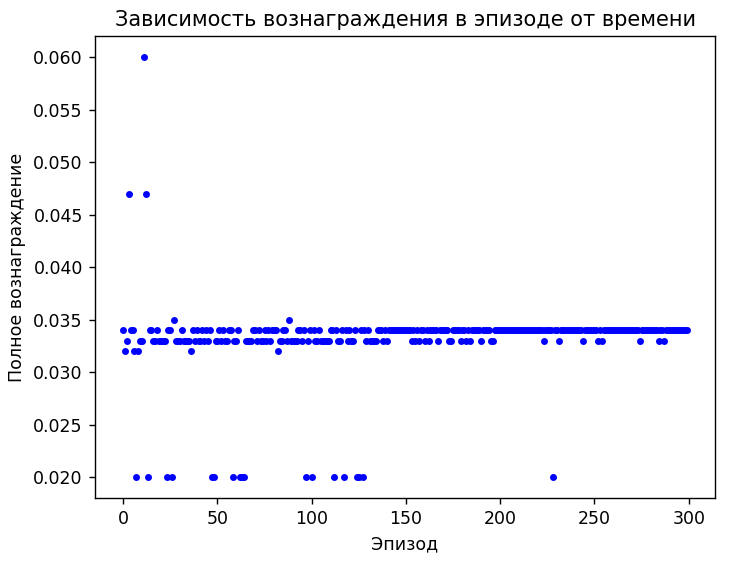

# Задание 3. Алгоритм Актор-Критик

Градиент политики слишком случаен, у Reinforcement слишком большая дисперсия, а Reinforcement with baseline очень медленно и долго сходится. Вот и остаётся только надеяться на Актора и на Критика

In [37]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel, self).__init__()
        self.fc = nn.Linear(n_input, n_hidden)
        self.action = nn.Linear(n_hidden, n_output)
        self.value = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        x = torch.Tensor(x)
        x = F.mish(self.fc(x))
        action_probs = F.softmax(self.action(x), dim=-1)
        state_value = self.value(x)
        return action_probs, state_value

In [23]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)

    def predict(self, s):
        return self.model(torch.tensor(s))

    def update(self, returns, log_probs, state_values):
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(value, Gt)
            loss += policy_loss + value_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        ac_probs, state_value = self.predict(s)
        action = torch.multinomial(ac_probs, 1).item()
        log_prob = torch.log(ac_probs[action])
        return action, log_prob, state_value

In [36]:
def actor_critic(env, estimator, n_episode, gamma=1.0):
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state_values = []

        info = env.reset()
        state = np.array(list(info[1]['pipes'][-1].values()) + list(info[1]['bird'].values()))
        while True:
            action, log_prob, state_value = estimator.get_action(state.astype(np.float32))
            
            new_state, reward, is_done, __,  info = env.step(action)
            near_pipe = min(info['pipes'], key= lambda x: abs(x['x'] - info['bird']['x']))
            next_state = np.array(list(near_pipe.values()) + list(info['bird'].values()))
            
            total_reward_episode[episode] += reward

            log_probs.append(log_prob)
            rewards.append(reward)
            state_values.append(state_value)

            if is_done:
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.Tensor(returns)

                returns = (returns - torch.mean(returns)) / (torch.std(returns) + 1e-9)

                estimator.update(returns, log_probs, state_values)

                if total_reward_episode[episode] >= 195:
                    estimator.schedufler.step()

                print(f'Episode: {episode}, total reward: {total_reward_episode[episode]}')
                break

            state = next_state

In [43]:
n_state = 6
n_action = env.action_space.n
n_hidden = 1024
lr = 0.0001

policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

gamma = 0.9
n_episode = 200

total_reward_episode = [0] * n_episode

actor_critic(env, policy_net, n_episode, gamma)

Episode: 0, total reward: 0.03400000000000002
Episode: 1, total reward: 0.03400000000000002
Episode: 2, total reward: 0.024000000000000014
Episode: 3, total reward: 0.03400000000000002
Episode: 4, total reward: 0.03400000000000002
Episode: 5, total reward: 0.02000000000000001
Episode: 6, total reward: 0.02000000000000001
Episode: 7, total reward: 0.02000000000000001
Episode: 8, total reward: 0.06500000000000004
Episode: 9, total reward: 0.02000000000000001
Episode: 10, total reward: 0.02000000000000001
Episode: 11, total reward: 0.02000000000000001
Episode: 12, total reward: 0.02000000000000001
Episode: 13, total reward: 0.03400000000000002
Episode: 14, total reward: 0.02000000000000001
Episode: 15, total reward: 0.02000000000000001
Episode: 16, total reward: 0.02000000000000001
Episode: 17, total reward: 0.02000000000000001
Episode: 18, total reward: 0.02000000000000001
Episode: 19, total reward: 0.02000000000000001
Episode: 20, total reward: 0.02000000000000001
Episode: 21, total rew